In [584]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
from astropy import units as u
import matplotlib.pyplot as plt
import pandas as pd
import sys
import ipywidgets as wwid
# sys.path.insert(0, "..")
import tools.helpers as helpers
from tools.file_finder import find_file

import tools.file_finder

In [585]:
# root = r"Z:\OPTODOCS\1Leo\L_240521/"
# root = "./"
# root2 = "../../../OPTOSYNC/Tweezers1/"
date_nums = {
    # "210524":(2, 3, 4, 5, 6, 8, 9),
    # "210621":(3, 5, 7, 8),
    # "210609":(16, 17, 18, 19, 20),
    # "210525":(4, 6, 9),
    # "210610":(24, 25, 26, 29, 30),
    # "210611":(1, 2, 4, 5, 6, 9),
    # "210625":(),
    # "210810":(2,4),
    # "210831": (13, 14, 16, 17, 19, 20),
    # "210907": (3,),
    # "210910": (10, 11, 14, 15),#, 17, 18, 19, 20, 21)
    # "210914": (16, 17, 20, 21, 23),
    # "210917": (8, 11, 14, 15, 17)#, 18, 20, 23, 26, 29)
    # "210917": (23, 26, 29, 30, 31),
    # "210921": (30, 34, 36, 40, 41),
    # "210924": (44, 45, 46, 48),
    # "210928": (53, 56, 59, 61, 62, 63, 66, 67, 68, 69, 75, 76, 77, 74),
    "210928": (74,),
    # "211001": (6,7, 8, 10, 11, 12, 17, 19, 21, 22, 23, 
    # 24, 25, 26, 38,
    # 42,44,45,46,51,54,56),
    # ),
    # "211005": (59, 62, 65, 66, 68, 70, 72, 74, 79, 87, 88, 89)
    # "211008": (3, 5, 6, 10, 12, 13, 14, 16, 17, 18, 21, 22, 23, 25, 26, 27, 30, 32),
    "211012":(36, 38, 39, 40, 41, 42, 43, 44, 51, 53, 55, 57, 59, 60, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79)
}

keys = [[(k, v) for v in n] for k, n in date_nums.items()]
for k in list(keys):
    keys.remove(k)
    keys += k
keys_nice = [f"{a}-{b}" for a, b in keys]
DI = lambda n, date: keys.index((date,int(n)))
def DIn(*n):
    """ The first argument should be the date """
    date = n[0]
    return [DI(n_, date) for n_ in n[1:]]

rabi_files = []
rabi_plot_files = []
for date, date_n in date_nums.items():
    for n in date_n:
        rabi_files.append(find_file("NV", n, date, True))
        rabi_plot_files.append(find_file("NV", n, date))



rabi_specs = [pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in rabi_files]
rabi_plots = [np.genfromtxt(f, skip_header=20).T for f in rabi_plot_files]
MW_freqs = []
MW_pows = []
for f in rabi_files:
    freq, powr = helpers.get_val_from_file(f, "RF freq.", "RF power")
    MW_freqs.append(freq)
    MW_pows.append(powr)
MW_freqs = np.array(MW_freqs)
MW_pows = np.array(MW_pows)

# test_time = np.arange(30000)
# test_signal = np.sin(1e-1*test_time**(0.7))
# m = test_signal > 0.75
# test_signal[m] = 10 + 3e-5 * test_time[m]
# test_signal[~m] = 0.
# plt.plot(test_time, test_signal)
# test_data = pd.DataFrame({"counts": test_signal, "time":test_time})
test_data = pd.read_csv("sim_out.txt", sep=" ", names=("time", "counts"))
rabi_specs = [test_data] + rabi_specs
rabi_files = ["test signal"] + rabi_files

raw_titles = [x[-20:] for x in rabi_files]
proc_titles = [x[-20:] for x in rabi_plot_files]

Caching...
Done.
Caching...
Done.


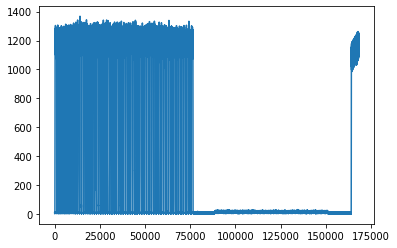

In [586]:
plt.plot(rabi_specs[-1].counts)

In [587]:
plot_col = None
n_cols = 4
n_rows = (n_cols - 1 + len(rabi_plots)) // n_cols

tau_axes = [r[0] for r in rabi_plots]

if plot_col is not None:
    fig = plt.figure(figsize=(n_cols*6, n_rows*5))
    axes = fig.subplots(
        nrows=n_rows, 
        ncols=n_cols, sharex="none").flatten()
    for i, (tau, plot) in enumerate(zip(tau_axes, rabi_plots)):
        ax = axes[i]
        ax.set_title(proc_titles[i])
        data = plot[plot_col]
        z_mask = data != 0.
        smoothed = g_filter(data[z_mask], 3)
        ax.plot(tau[z_mask], data[z_mask], '.-')
        ax.plot(tau[z_mask], smoothed, 'r--')

    plt.show()
# plt.plot(*rabi_plots[2][[0,6]])

## Find start/end of each pulse and determine signal/reference windows

In [588]:
integration_width_f, integration_width_b = 300, 800 # ns
forwards_shift = 0  # Read signal shift
backwards_shift = -40 # Ref signal shift
first_pulse, last_pulse = 0, 10
extra_dead_time = 50
show_pulse = [ -1,
    DI(74, "210928"),
    # *DIn("211001", 6, 12, 25, 26, 19, 23),
    DI(68, "211012"),
    len(rabi_specs)-2
]

drop_ends = [0.05 for _ in rabi_specs]
drop_ends = [0.1] + drop_ends

normalised = [
    *DIn("211012", 68, 76)
]

In [589]:
# lst1 = ["211008", 3, 5, 6, 10, 12, 13, 14, 16, 17, 18, 21, 22, 27, 30, 32]
tau_vectors = [None for _ in rabi_specs]

lst1 = ["211012", *date_nums["211012"]]
for i in DIn(*lst1):
    if i in normalised:
        tau_vectors[i] = np.tile(np.linspace(20, 1000, 50).reshape(-1, 1), (1, 2)).flatten()
    else:
        tau_vectors[i] = np.linspace(20, 1000, 60)
# tau_vectors[DI(25, "211008")] = np.linspace(20, 200, 60)
# tau_vectors[DI(26, "211008")] = np.linspace(200, 400, 60)
# print(tau_vectors[16])

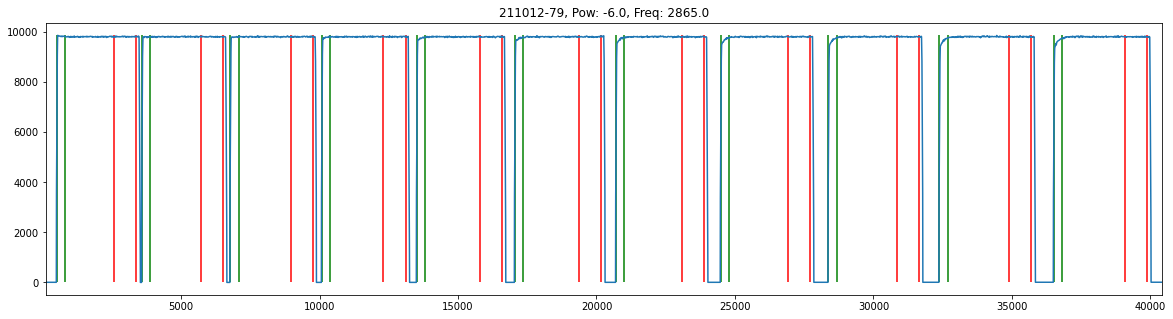

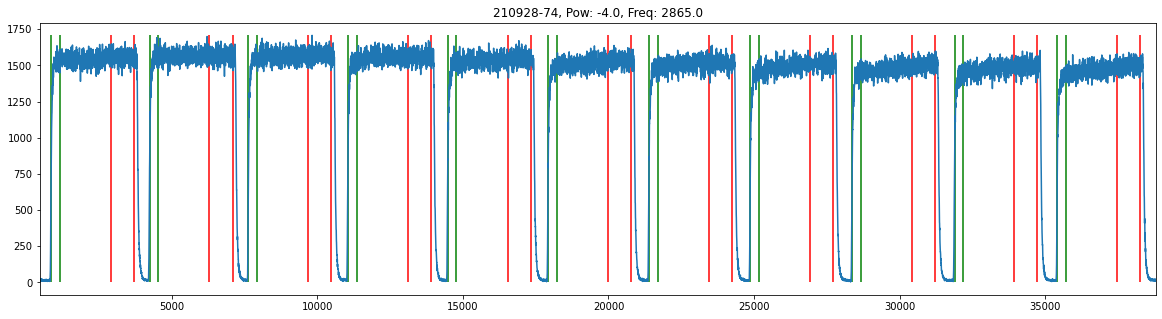

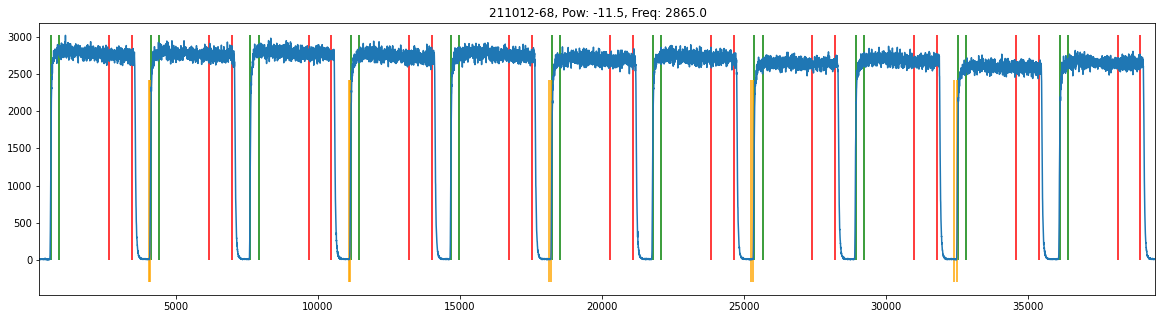

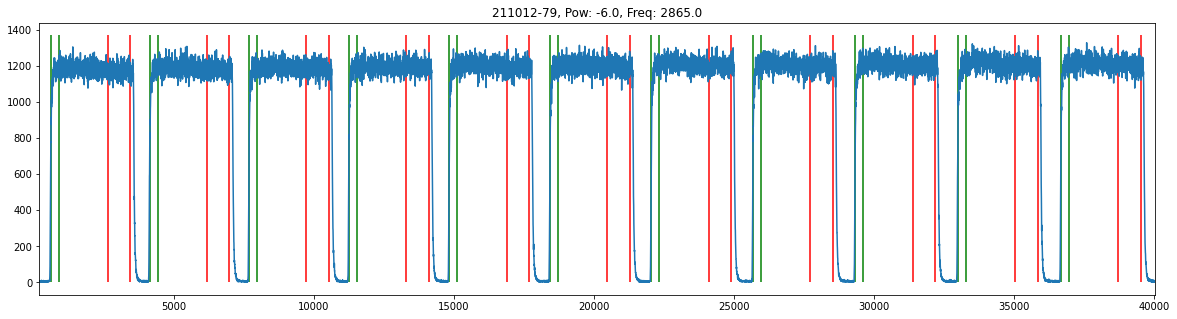

In [590]:
# Remember raw counts files are read in as panda dataframes

# Smooth raw data
for data, end_drop in zip(rabi_specs, drop_ends):
    if end_drop is not None:
        new_end = len(data.counts) * (1 - end_drop)
        new_end = int(new_end)
        data.counts = data.counts[:new_end]
        data.time = data.time[:new_end]
    data['smooth'] = g_filter(data.counts, sigma=4)

max_counts = np.array([max(data.smooth) for data in rabi_specs])
min_counts = np.array([min(data.smooth) for data in rabi_specs])

COUNTS_THRESHOLD = 0.50 # * the max number of counts in any bin

read_thresh = COUNTS_THRESHOLD * (max_counts - min_counts) + min_counts
# laser_thresh = 0.1*(max_counts - min_counts) + min_counts

ris_fals = [
    helpers.get_rise_falls(np.array(data.smooth), thresh)
    for data, thresh in zip(rabi_specs, read_thresh)
]


rises = [rf[0] for rf in ris_fals]
# rises[-1] = rises[-1][1:]
falls = [rf[1] for rf in ris_fals]
# falls[-1] = falls[-1][1:]

rise_ts = [np.array(data.time[r]) for data, r in zip(rabi_specs, rises)]
fall_ts = [np.array(data.time[f]) for data, f in zip(rabi_specs, falls)]

################################################################
dt = np.array([spec.time[1] - spec.time[0] for spec in rabi_specs])
int_width_b = (integration_width_b // dt).astype(int)
int_width_f = (integration_width_f // dt).astype(int)

################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
drop_first_pulse = True
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        rabi_specs, rises, falls, rise_ts, fall_ts)):
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)

    if  i-1 in show_pulse: # i-1 because the test one will be first
        plt.figure(figsize=(20, 5))
        plt.plot(spec.time, spec.counts)
        plt.title(f"{keys_nice[i-1]}, Pow: {MW_pows[i-1]}, Freq: {MW_freqs[i-1]}")
        top = max(spec.counts)
        plt.vlines(forwards_shift*dt[i] + s_rise_ts, 0, top, "green")
        plt.vlines(forwards_shift*dt[i] + s_rise_ts + dt[i]*int_width_f[i], 0, top, "green")
        plt.vlines(backwards_shift*dt[i] + s_fall_ts, 0, top, "red")
        plt.vlines(backwards_shift*dt[i] + s_fall_ts - dt[i]*int_width_b[i], 0, top, "red")
        if i-1 in normalised:
            # Show MW regions
            plt.vlines(forwards_shift*dt[i] + s_rise_ts[1::2] - 30, -.1*top, .8*top, "orange")
            plt.vlines(forwards_shift*dt[i] + s_rise_ts[1::2] - 30 - tau_vectors[i-1][::2], -.1*top, .8*top, "orange")
        # plt.xlim(0, s_fall_ts[5])
        plt.xlim(s_rise_ts[first_pulse]-400, s_fall_ts[last_pulse]+400)
        f = False
        plt.show()


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = False # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
PL_read_errs = []  # Errors are fractional
PL_ref_errs = []   # Errors are fractional
normalised_flags = np.full(len(rabi_specs), False)
for i, (spec, start_end, start_end_idx, int_w_f, int_w_b) in enumerate(zip(
        rabi_specs, start_ends, start_ends_idx, int_width_f, int_width_b)):
    if i == 0:
        int_w_b = int_w_f
    forward_t = np.arange(int_w_f)
    backward_t = -np.arange(int_w_b)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = np.tile(backward_t, (len(start_end_idx)-x, 1))
    forward += forwards_shift
    backward += backwards_shift
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:len(start_end_idx)-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1] + dt[i]*(backwards_shift - forwards_shift)
    tau -= extra_dead_time * dt[i]
    # if not take_previous_fall ignore the first pulse
    reads_i = reads[1-x:]
    refs_i  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads_i], axis=-1)
    refs  = np.sum(arr[refs_i], axis=-1)
    noise = np.std(arr[refs_i], axis=-1) / np.mean(arr[refs_i], axis=-1)
    
    # if i-1 in normalised:
    #     plt.plot(reads[::2])
    #     plt.plot(reads[1::2])
    #     plt.show()
    #     reads = reads[::2] / reads[1::2]
    #     refs = refs[::2] / refs[1::2]
    #     noise = noise[::2]
    #     tau = tau[::2]

    refs_err = noise / np.sqrt(int_w_b)
    read_err = noise / np.sqrt(int_w_f)
    reads /= int_w_f
    refs /= int_w_b


    # if np.any(np.diff(tau) < -10):
    #     # Probably data that includes normalisation, ie a background sweep.
    #     # divide the first half by the second half
    #     indx = np.flatnonzero((tau[1:]-tau[:-1]) < -10)[0]
    #     # print(i, ": ", end="")
    #     # print(len(reads), len(refs), indx)
    #     normalised_flags[i] = True
    #     # if indx == 0:
    #         # print(np.diff(tau))
    #     # print("Fixing %s which was run with 'normalise' turned on" % rabi_files[i][-30:])
    #     reads = reads[:indx+1] / reads[indx+1 + (1-x):]
    #     refs = refs[:indx+1] / refs[indx+1 + (1-x):]
    #     # if i > 25:
    #     tau = tau[:indx+1]


    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_read_errs.append(read_err)
    PL_refs.append(refs)
    PL_ref_errs.append(refs_err)

# PL_reads[-1] = PL_reads[-1][1:]
# PL_refs[-1] = PL_refs[-1][1:]
# spec_tau_axes[-1] = spec_tau_axes[-1][1:]


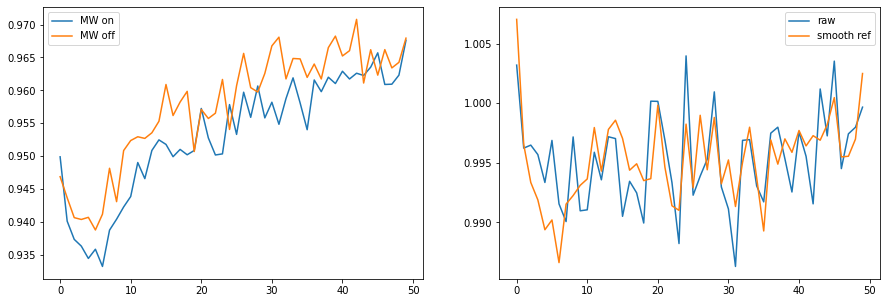

In [591]:
n = DI(76, "211012")
read_n = PL_reads[n+1]
ref_n = PL_refs[n+1]
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(ncols=2).flatten()
MW_signal = read_n[::2] / ref_n[::2]
norm_signal = read_n[1::2] / ref_n[1::2]
ax1.plot(MW_signal, label="MW on")
ax1.plot(norm_signal, label="MW off")
ax1.legend()
ax2.plot(MW_signal / norm_signal, label="raw")
ax2.plot(MW_signal / g_filter(norm_signal, sigma=5), label="smooth ref")
ax2.legend()

3 9


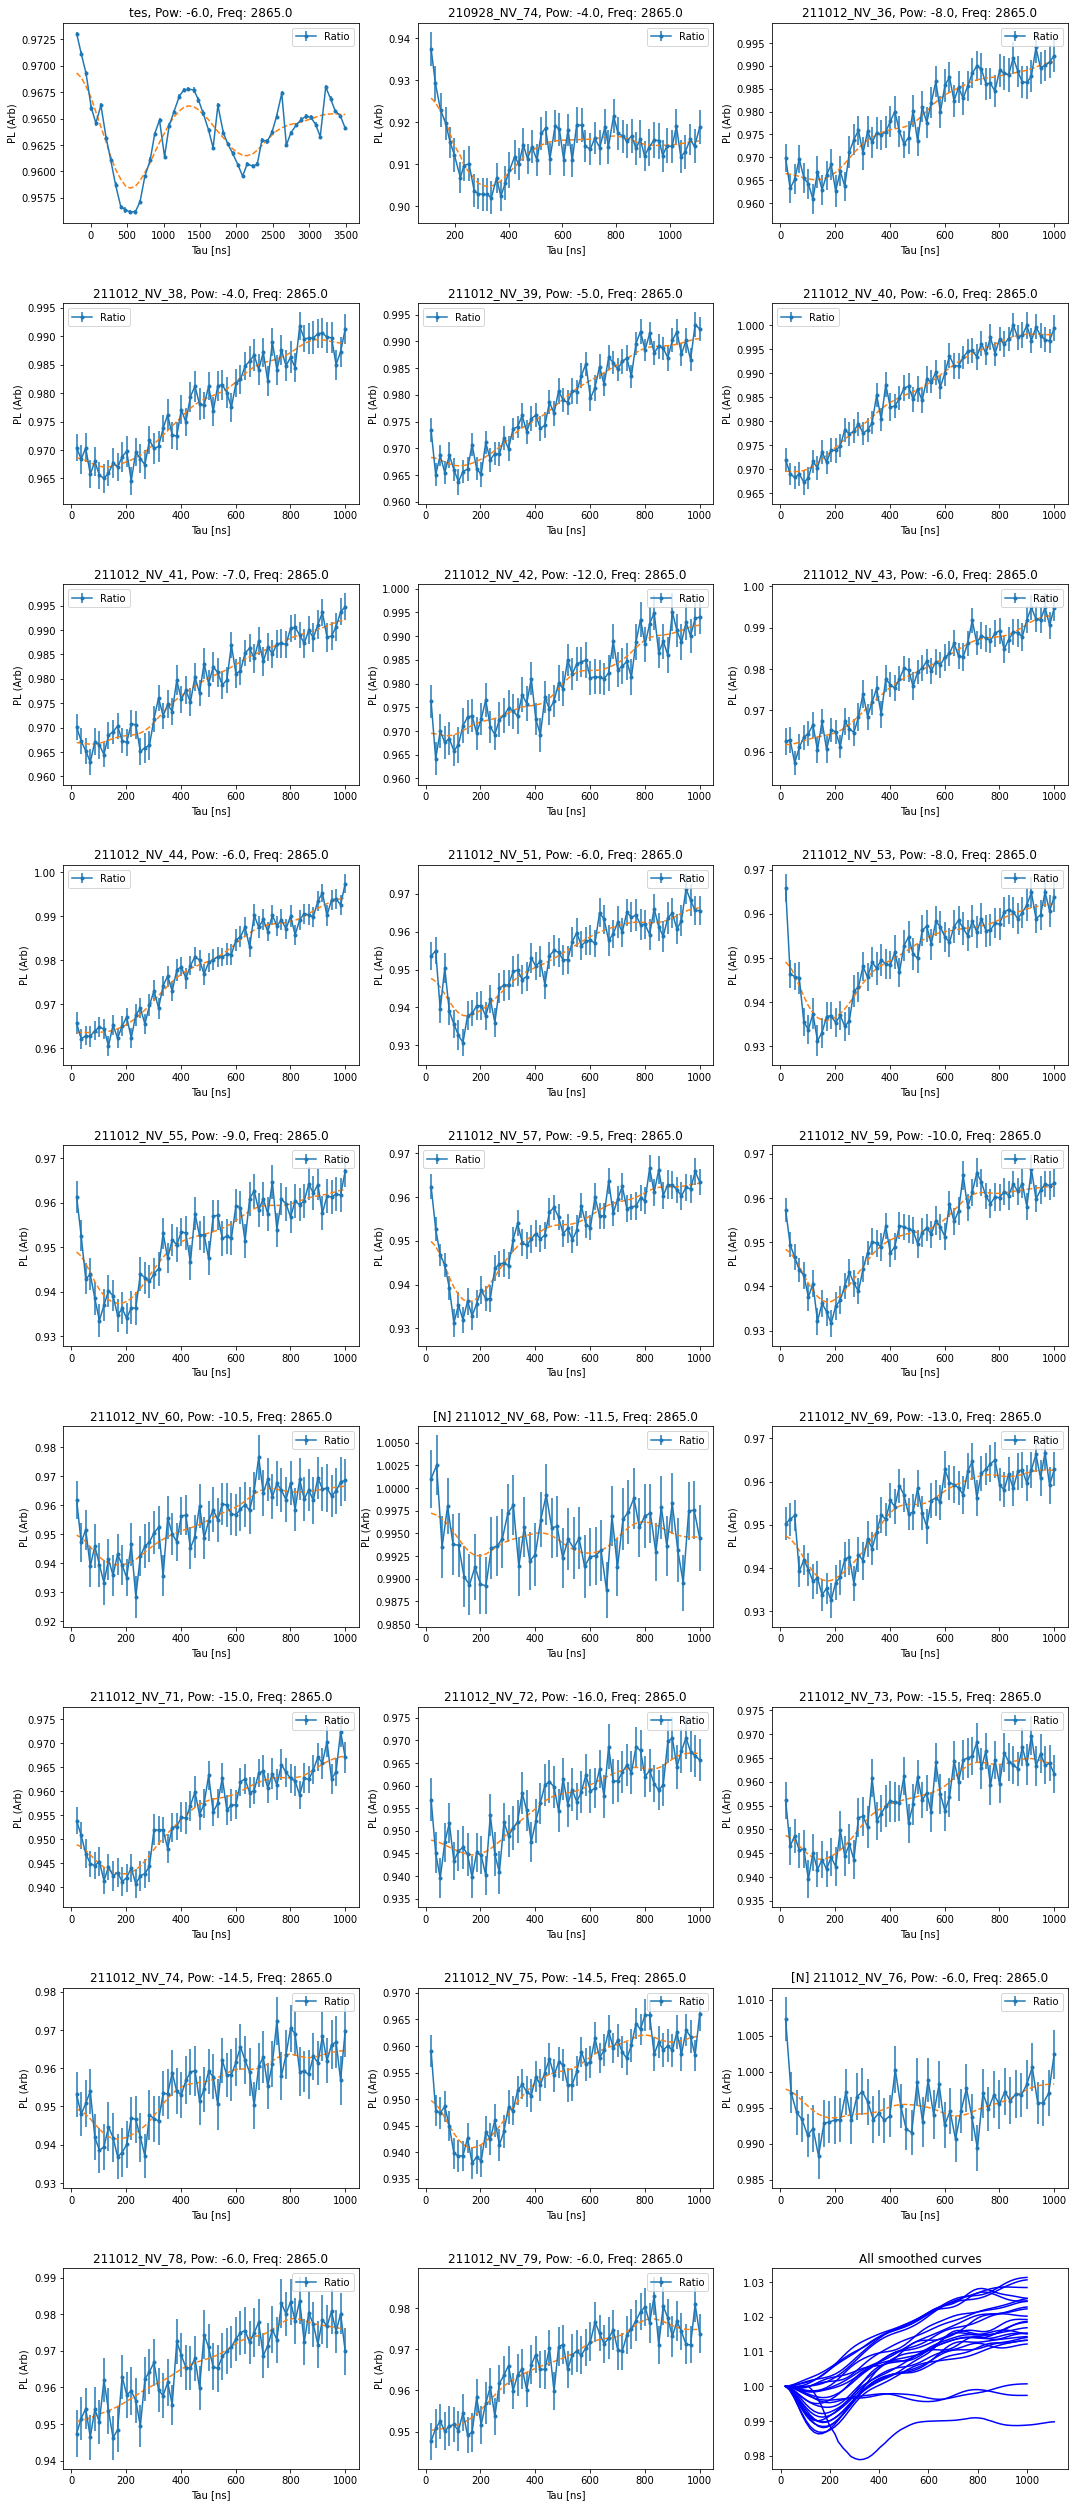

In [592]:
smoothed_series = None
save_plots = True
# @wwid.interact(graph_type=["Ratio", "Difference", "Both"])
def _do_plot(graph_type="Ratio"):
    global smoothed_series
    n_cols = 3
    n_rows = (len(rabi_files)+n_cols-1+1)//n_cols # +1 for the totals plot at the end
    fig = plt.figure(figsize=(n_cols*6, 5*n_rows))
    print(n_cols, n_rows)
    smoothing_sigma = 3

    axes = fig.subplots(
        nrows=n_rows,
        ncols=n_cols,
        sharex="none").flatten()
    smoothed_series = []
    for i, (title, tau, read, read_err, ref, ref_err, ax) in enumerate(
            zip(raw_titles, spec_tau_axes, PL_reads, PL_read_errs, PL_refs, PL_ref_errs, axes)):
        if normalised_flags[i] or i-1 in normalised:
            title = "[N] " + title
        if tau_vectors[i-1] is not None:
            tau = tau_vectors[i-1]
            read = read[:len(tau)]
            ref = ref[:len(tau)]
        read = read
        ref  = ref
        ax.set_title(title[:-8] + ", Pow: " + str(MW_pows[i-1]) + ", Freq: " + str(MW_freqs[i-1]))
        diff = ref - read
        ratio = read / ref
        diff = diff / max(diff) * ratio[0]
        smooth_diff = g_filter(diff, smoothing_sigma)
        smooth_ratio = g_filter(ratio, smoothing_sigma)
        smooth_read = g_filter(read, smoothing_sigma)
        smooth_ref = g_filter(ref, smoothing_sigma)
        if i-1 in normalised:
            signal = ratio[::2]
            norm = ratio[1::2]
            smooth_norm = g_filter(norm, smoothing_sigma)
            smooth_ratio = ( g_filter(signal, smoothing_sigma) / smooth_norm )
            # ratio = ratio[::2]

            # smooth_read = smooth_read[::2] / smooth_read[1::2]
            # smooth_ratio = smooth_ratio[::2] / smooth_ratio[1::2]
            tau = tau[::2]
            read_err = read_err[::2]
            ref_err = ref_err[::2]
            ratio = signal / smooth_norm
        if graph_type == "Difference":
            ax.plot(tau, diff, "-", label="Diff") 
        elif graph_type == "Ratio":
            # Add fractional uncertainties
            # if i>0: print(ratio * ref_err/ref)
            ratio_err = (read_err + ref_err) * ratio

            ax.errorbar(tau, ratio, yerr=ratio_err, fmt=".-", label="Ratio"); ax.plot(tau, smooth_ratio, "--")
            if not "test" in title:
                smoothed_series.append((tau, smooth_ratio))
        elif graph_type == "Both":
            ax.plot(tau, read, label="PL Read")
            ax.plot(tau, ref, label="PL Ref")
        ax.set_xlabel("Tau [ns]")
        ax.set_ylabel("PL (Arb)")
        ax.legend()
        # break
    # ax.set_xlim(4000,10000)
    # ax.set_ylim(0.97, 1.025)
    if smoothed_series:
        for i, series in enumerate(smoothed_series):
            axes[-1].plot(series[0], .00*i+1+series[1] - series[1][0], "blue")
        axes[-1].set_title("All smoothed curves")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    # slc = slice(1, 5)
_do_plot(graph_type="Ratio")

    # avg = np.sum([read/ref for read, ref in zip(PL_reads[slc], PL_refs[slc])], axis=0)
    # plt.plot(spec_tau_axes[1], avg)

In [593]:
rd = lambda date, *n : [DI(n_, date) for n_ in n]
reversed = [
    # *rd("211001", 12), #r2(26)
]
off_res = [
    # *rd("211001", 19)
]
amp_off = [
    # *rd("211001", 23), *rd("211008", 6, 17, 18)
    *rd("211012", 40, 78, 79)
]
normalise = True
norm_tau, norm_array = smoothed_series[DI(79, "211012")]
# runs = [*rd("211008", 6, 10, 12, 13, 14, 16, 17, 18,)]# 21, 22, 27, 29)]
runs = [*rd("211012", 40, *date_nums["211012"][9:])]#*date_nums["211012"])]
runs.remove(DI(68, "211012"))
runs.remove(DI(76, "211012"))

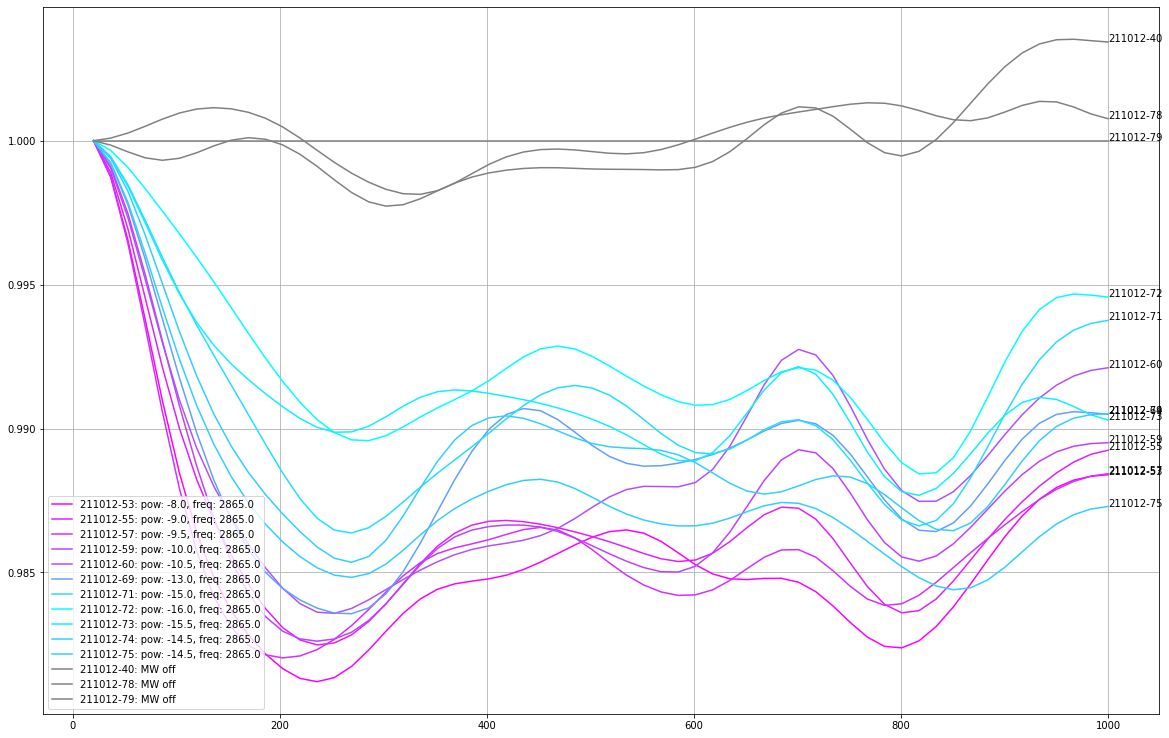

In [594]:
# Plot normalised rabi curves
# r = lambda n : DI(n, "210928")
r2 = lambda *n : [DI(n_, "211001") for n_ in n] if len(n) > 1 else DI(n[0], "211001")


# reversed = [
#     r2(12), #r2(26)
# ]
# off_res = [
#     *rd("211001", 19)
# ]
# amp_off = [
#     *rd("211001", 23), *rd("211008", 6, 17)
# ]
# run_nums = []#6, 7, 8, 10, 11, 12, 19, 23]#, 17, 21, 22, 24, 25, 19, 23]
# # run_nums = [23, 22, 21, 24, 25, 26][2:]
# runs = [*rd("211001", *run_nums), *rd("211008", 6, 10, 12, 13, 14, 16, 17)]
powered_runs = np.array([r for r in runs if r not in amp_off])


# runs = [i for i in range(len(rabi_specs)-1)]
pow_range = MW_pows[powered_runs] #np.array([n for n in runs], dtype=float)
pow_0to1 = pow_range - min(pow_range)
if not np.all(pow_0to1 == 0):
    pow_0to1 /= max(pow_0to1)


cmap = plt.cm.cool(pow_0to1)
plt.figure(figsize=(20, 13))
off_runs = [r for r in runs if r in amp_off]
all_runs = list(powered_runs) + off_runs
all_clrs = list(cmap) + ["k"] * len(off_runs)
normalised_series = [None for _ in smoothed_series] 
for n, c in zip(all_runs, all_clrs):
    tau_ax, vals = smoothed_series[n]
    if n in reversed:
        vals = vals[::-1]
        tau_ax = tau_ax[::-1]
    if n in off_res:
        c = "black"
    if n in amp_off:
        c = "gray"
    if normalise:
        vals = vals / np.interp(x=tau_ax, xp=norm_tau, fp=norm_array)
        normalised_series[n] = (tau_ax, vals)
        # vals = vals / norm_array
    vals = vals - vals[0] + 1
    if n in off_runs:
        l = f"{keys_nice[n]}: MW off"
    else:
        l = f"{keys_nice[n]}: pow: {MW_pows[n]}, freq: {MW_freqs[n]}"
    plt.plot(tau_ax, vals, color=c, label=l)
    plt.annotate(f"{keys_nice[n]}", (tau_ax[-1], vals[-1]))
plt.grid()
plt.legend()
plt.show()


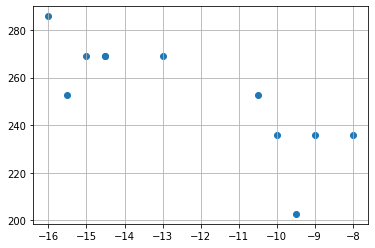

In [595]:
# Find location of dip bottom
pows = []
pi_times = []
for n in powered_runs:
    n_pow = MW_pows[n]
    tau, smooth = normalised_series[n]
    grad = np.diff(smooth, append=0.965)
    # plt.plot(tau,smooth-0.98)
    # plt.plot(tau,grad)
    # print(n_pow)
    # plt.grid()
    # plt.show()
    min_tau = tau[grad>0][0]
    pows.append(n_pow)
    pi_times.append(min_tau)
plt.grid()
plt.scatter(pows, pi_times)

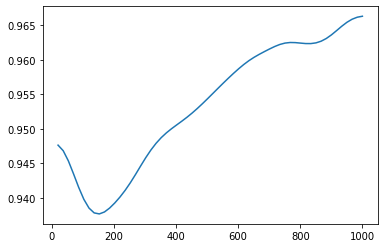

In [596]:
plt.plot(*smoothed_series[DI(51, "211012")])

In [597]:
# PL_read_errs
PL_ref_errs[-1],PL_refs[-1]

(array([0.00180444, 0.00188736, 0.00170367, 0.00184583, 0.00197643,
        0.00173101, 0.00191799, 0.00182511, 0.00177826, 0.00190525,
        0.00181274, 0.00184242, 0.00201354, 0.00176311, 0.00179777,
        0.00175301, 0.00179898, 0.00186649, 0.00174157, 0.00202071,
        0.00191661, 0.00168259, 0.00190173, 0.00174183, 0.00178606,
        0.00185562, 0.0017354 , 0.00181579, 0.00186691, 0.0018383 ,
        0.00178547, 0.00193204, 0.00197973, 0.00179826, 0.00175848,
        0.00181615, 0.0018907 , 0.00170798, 0.00177724, 0.00197959,
        0.00185631, 0.00193403, 0.00176732, 0.00175955, 0.00190532,
        0.00193112, 0.0017717 , 0.00177696, 0.00187328, 0.00174636,
        0.00181128, 0.00175304, 0.00178983, 0.00192281, 0.00189459,
        0.00175499, 0.00189204, 0.00175589, 0.00163801, 0.00185042]),
 array([1181.06425703, 1185.3253012 , 1191.12851406, 1191.96385542,
        1193.64658635, 1199.35341365, 1196.74297189, 1201.37349398,
        1200.12449799, 1204.95582329, 1202.927